In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('/kaggle/working/notebook/experiment/v1/')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'efficientnet-b0'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 25

    lr = 1e-4
    loss = "DiceLoss"

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        # A.OneOf([
        #         A.GaussNoise(var_limit=[10, 50]),
        #         A.GaussianBlur(),
        #         A.MotionBlur(),
        #         ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
        #                 mask_fill_value=0, p=0.5),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



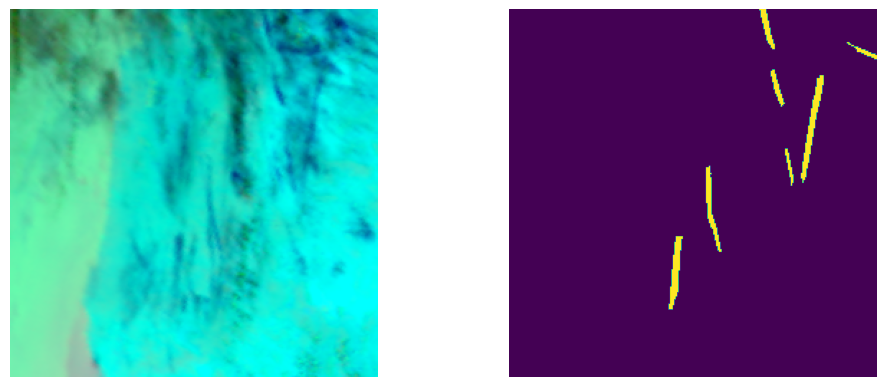

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(112, dataset_train)

# Model

In [6]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  efficientnet-b0


In [7]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [8]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/25  Mem : 3.56GB  LR : 1.00E-04  Loss: 0.8217: 100%|██████████| 642/642 
Val Loss: 0.6899: 100%|██████████| 58/58 [00:02<00:00, 21.35it/s]               


FBeta : 0.4712	thresh : 0.57	SAVED MODEL



Epoch 1/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.4826: 100%|██████████| 642/642 
Val Loss: 0.5598: 100%|██████████| 58/58 [00:02<00:00, 20.31it/s]               


FBeta : 0.4834	thresh : 0.87	SAVED MODEL



Epoch 2/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.4324: 100%|██████████| 642/642 
Val Loss: 0.5049: 100%|██████████| 58/58 [00:02<00:00, 22.13it/s]               


FBeta : 0.5393	thresh : 0.03	SAVED MODEL



Epoch 3/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.4144: 100%|██████████| 642/642 
Val Loss: 0.4771: 100%|██████████| 58/58 [00:02<00:00, 21.39it/s]               


FBeta : 0.5620	thresh : 0.03	SAVED MODEL



Epoch 4/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.4063: 100%|██████████| 642/642 
Val Loss: 0.4886: 100%|██████████| 58/58 [00:02<00:00, 22.98it/s]               


FBeta : 0.5605	thresh : 0.03



Epoch 5/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3986: 100%|██████████| 642/642 
Val Loss: 0.4593: 100%|██████████| 58/58 [00:02<00:00, 21.48it/s]               


FBeta : 0.5799	thresh : 0.13	SAVED MODEL



Epoch 6/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3899: 100%|██████████| 642/642 
Val Loss: 0.4645: 100%|██████████| 58/58 [00:02<00:00, 21.92it/s]               


FBeta : 0.5713	thresh : 0.95



Epoch 7/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3868: 100%|██████████| 642/642 
Val Loss: 0.4716: 100%|██████████| 58/58 [00:02<00:00, 21.58it/s]               


FBeta : 0.5730	thresh : 0.01



Epoch 8/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3796: 100%|██████████| 642/642 
Val Loss: 0.4544: 100%|██████████| 58/58 [00:02<00:00, 21.68it/s]               


FBeta : 0.5846	thresh : 0.83	SAVED MODEL



Epoch 9/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3764: 100%|██████████| 642/642 
Val Loss: 0.4400: 100%|██████████| 58/58 [00:02<00:00, 21.20it/s]               


FBeta : 0.5915	thresh : 0.27	SAVED MODEL



Epoch 10/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3686: 100%|██████████| 642/642
Val Loss: 0.4596: 100%|██████████| 58/58 [00:02<00:00, 20.86it/s]               


FBeta : 0.5790	thresh : 0.59



Epoch 11/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3642: 100%|██████████| 642/642
Val Loss: 0.4475: 100%|██████████| 58/58 [00:02<00:00, 21.77it/s]               


FBeta : 0.5914	thresh : 0.01



Epoch 12/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3628: 100%|██████████| 642/642
Val Loss: 0.4372: 100%|██████████| 58/58 [00:03<00:00, 18.45it/s]               


FBeta : 0.5979	thresh : 0.03	SAVED MODEL



Epoch 13/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3578: 100%|██████████| 642/642
Val Loss: 0.4361: 100%|██████████| 58/58 [00:03<00:00, 18.82it/s]               


FBeta : 0.5981	thresh : 0.49	SAVED MODEL



Epoch 14/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3533: 100%|██████████| 642/642
Val Loss: 0.4322: 100%|██████████| 58/58 [00:03<00:00, 18.99it/s]               


FBeta : 0.6045	thresh : 0.01	SAVED MODEL



Epoch 15/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3492: 100%|██████████| 642/642
Val Loss: 0.4346: 100%|██████████| 58/58 [00:03<00:00, 18.84it/s]               


FBeta : 0.6046	thresh : 0.01	SAVED MODEL



Epoch 16/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3446: 100%|██████████| 642/642
Val Loss: 0.4364: 100%|██████████| 58/58 [00:02<00:00, 21.27it/s]               


FBeta : 0.6035	thresh : 0.01



Epoch 17/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3400: 100%|██████████| 642/642
Val Loss: 0.4267: 100%|██████████| 58/58 [00:02<00:00, 21.93it/s]               


FBeta : 0.6117	thresh : 0.01	SAVED MODEL



Epoch 18/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3353: 100%|██████████| 642/642
Val Loss: 0.4293: 100%|██████████| 58/58 [00:02<00:00, 21.87it/s]               


FBeta : 0.6075	thresh : 0.01



Epoch 19/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3322: 100%|██████████| 642/642
Val Loss: 0.4174: 100%|██████████| 58/58 [00:02<00:00, 21.74it/s]               


FBeta : 0.6132	thresh : 0.07	SAVED MODEL



Epoch 20/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3290: 100%|██████████| 642/642
Val Loss: 0.4206: 100%|██████████| 58/58 [00:02<00:00, 21.18it/s]               


FBeta : 0.6132	thresh : 0.19	SAVED MODEL



Epoch 21/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3254: 100%|██████████| 642/642
Val Loss: 0.4173: 100%|██████████| 58/58 [00:02<00:00, 21.55it/s]               


FBeta : 0.6164	thresh : 0.03	SAVED MODEL



Epoch 22/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3227: 100%|██████████| 642/642
Val Loss: 0.4236: 100%|██████████| 58/58 [00:02<00:00, 21.49it/s]               


FBeta : 0.6132	thresh : 0.01



Epoch 23/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3215: 100%|██████████| 642/642
Val Loss: 0.4167: 100%|██████████| 58/58 [00:02<00:00, 21.52it/s]               


FBeta : 0.6178	thresh : 0.01	SAVED MODEL



Epoch 24/25  Mem : 3.76GB  LR : 1.00E-03  Loss: 0.3203: 100%|██████████| 642/642
Val Loss: 0.4143: 100%|██████████| 58/58 [00:02<00:00, 21.42it/s]               


FBeta : 0.6177	thresh : 0.03

{"status":200,"message":"ok"}

In [9]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']

model.to(device)
model.eval();


model_arch:  Unet
backbone:  efficientnet-b0


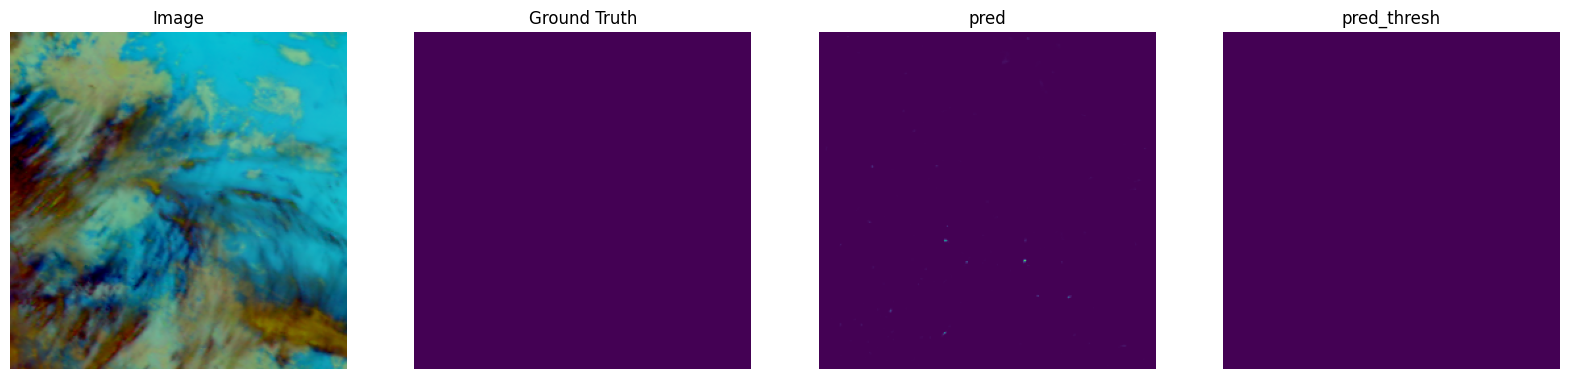

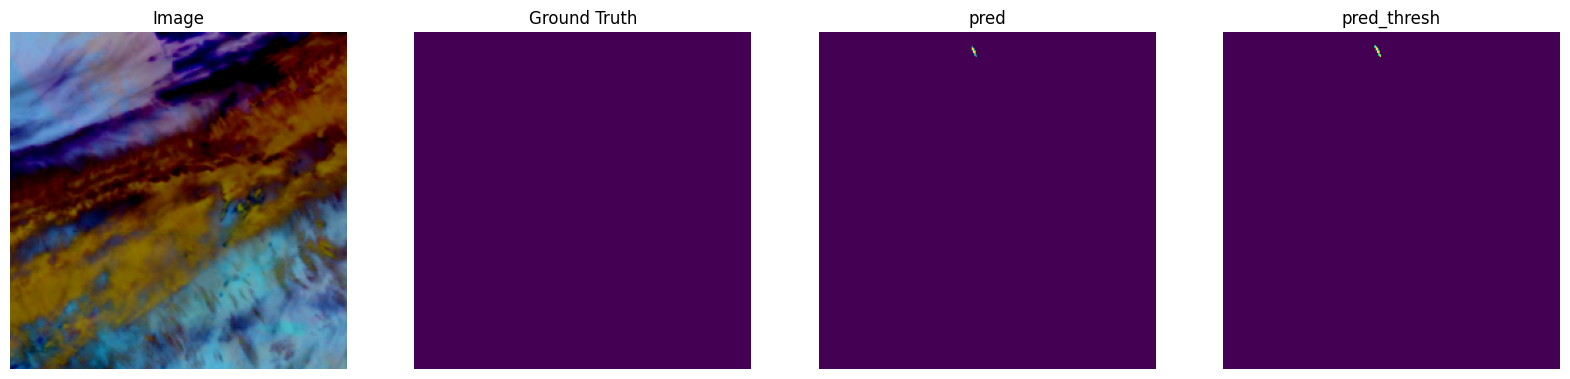

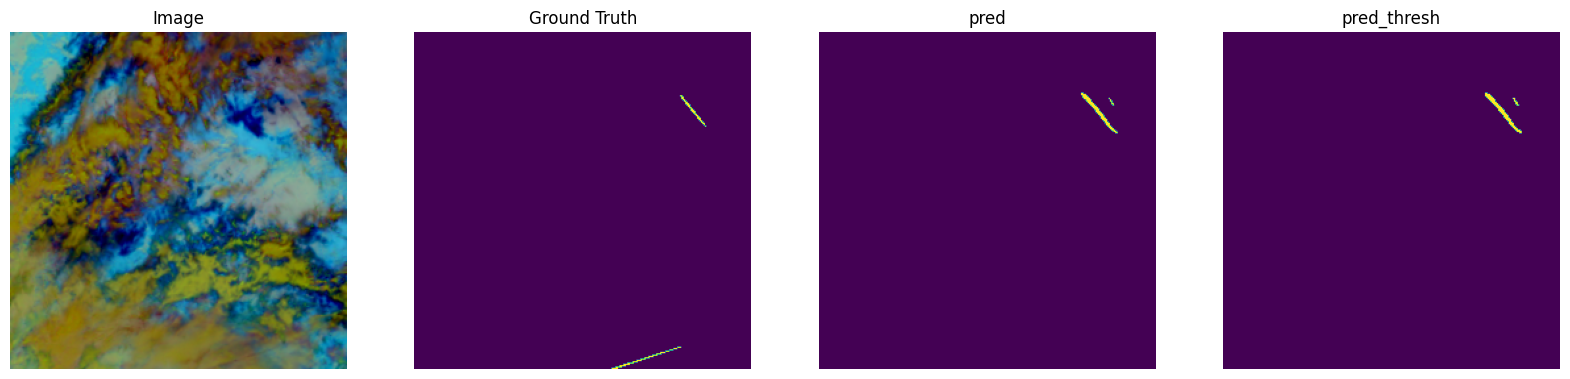

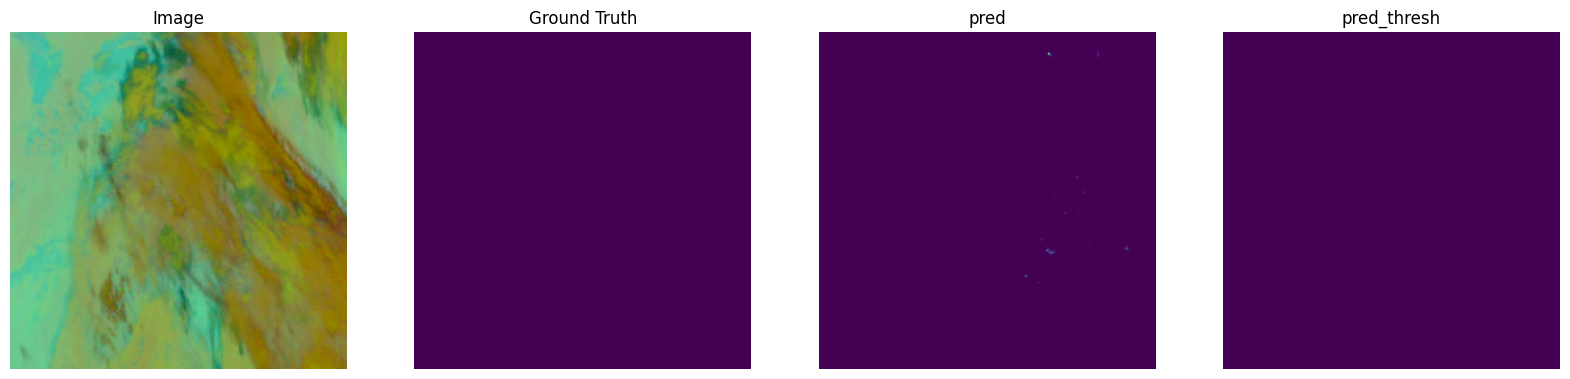

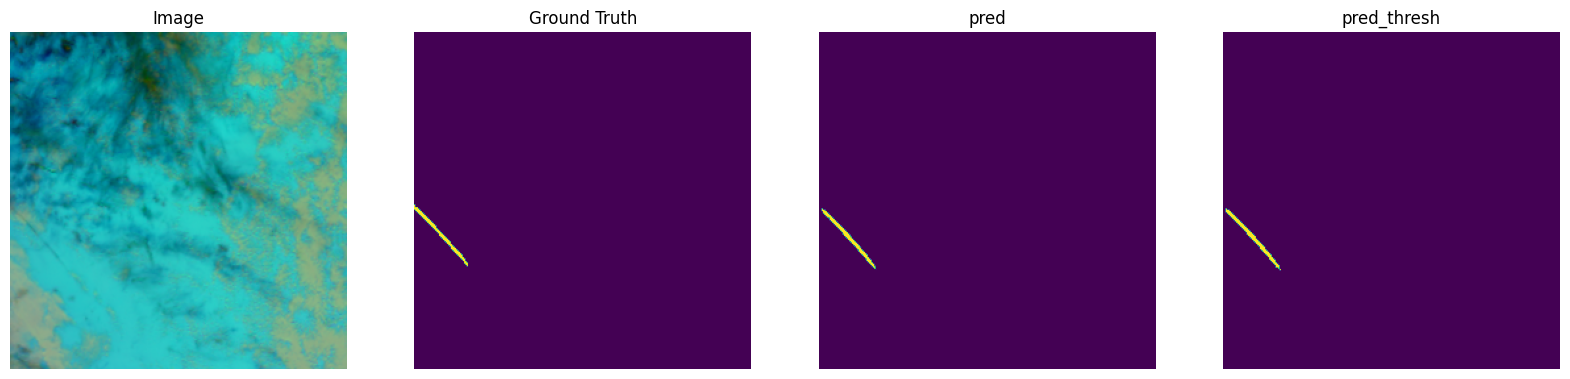

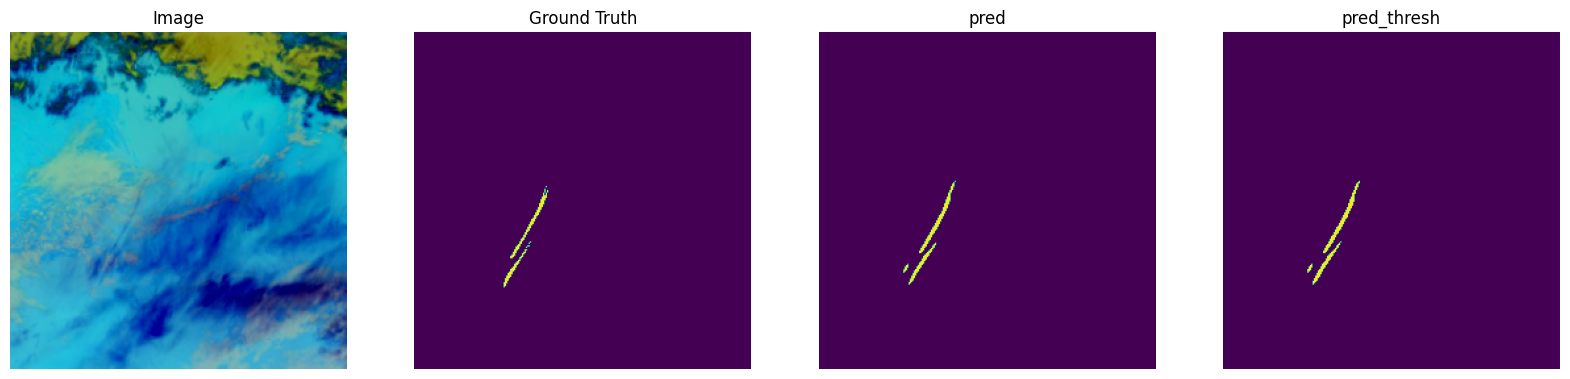

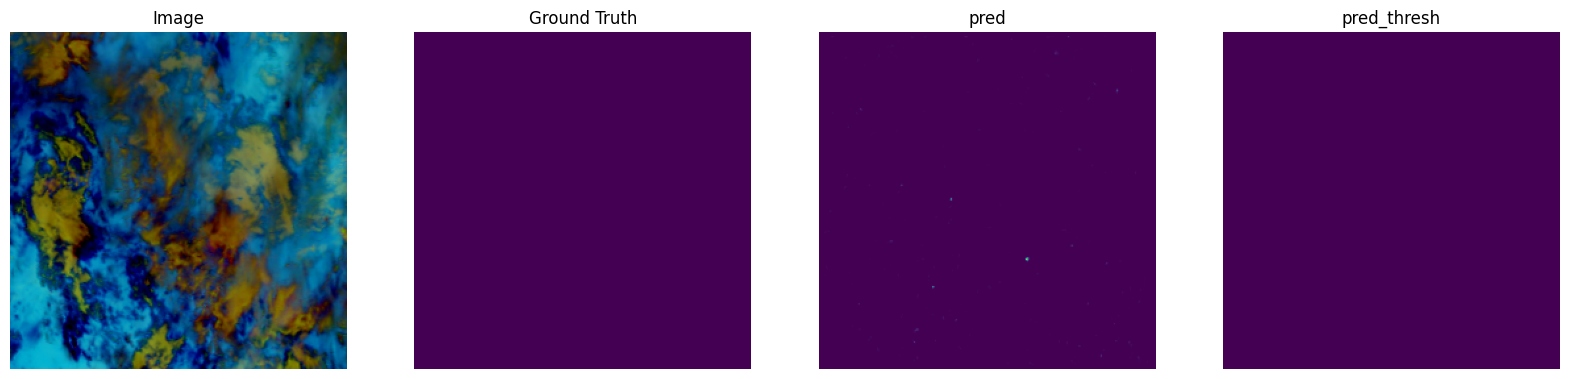

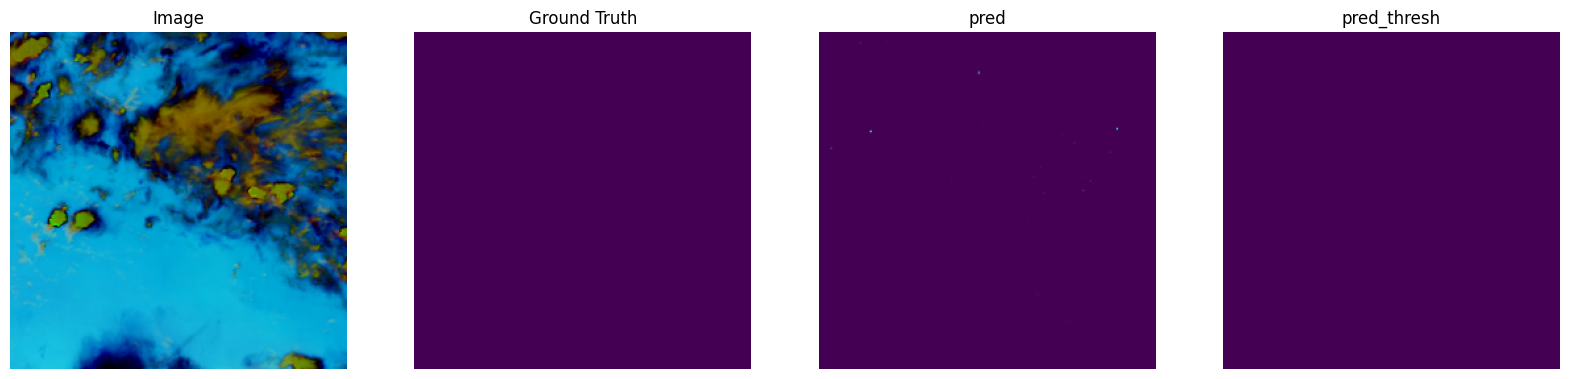

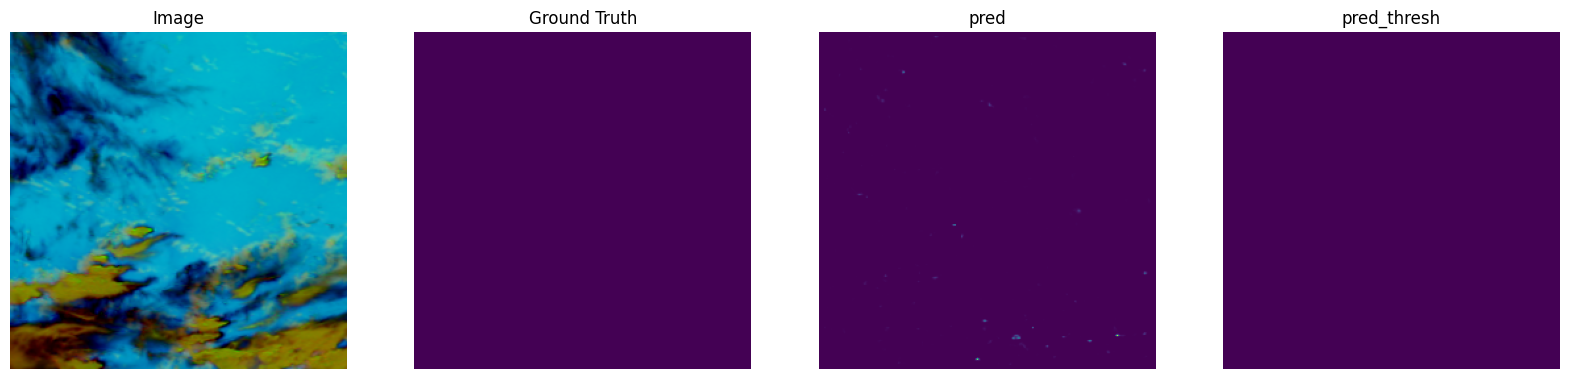

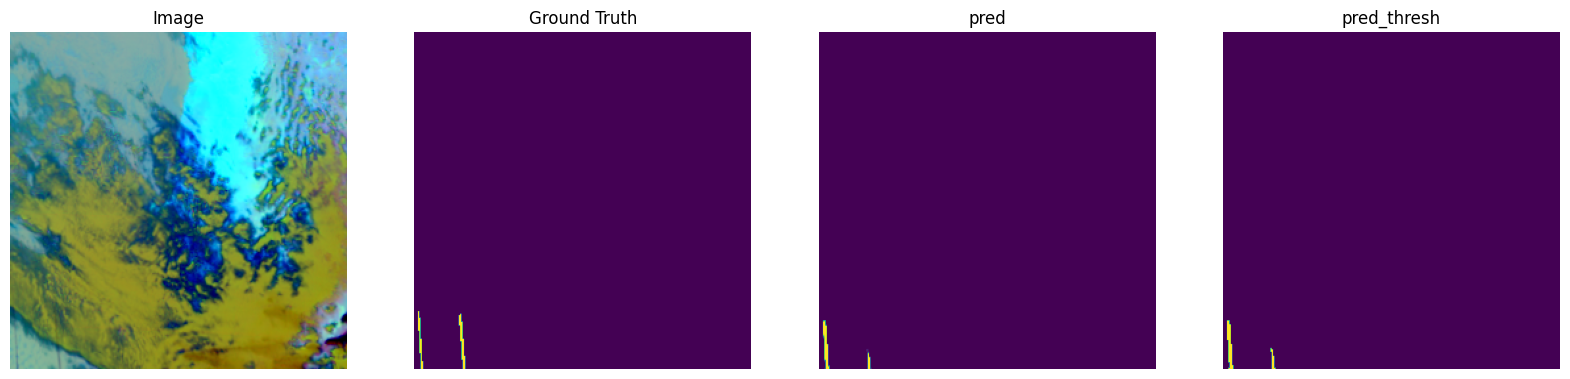

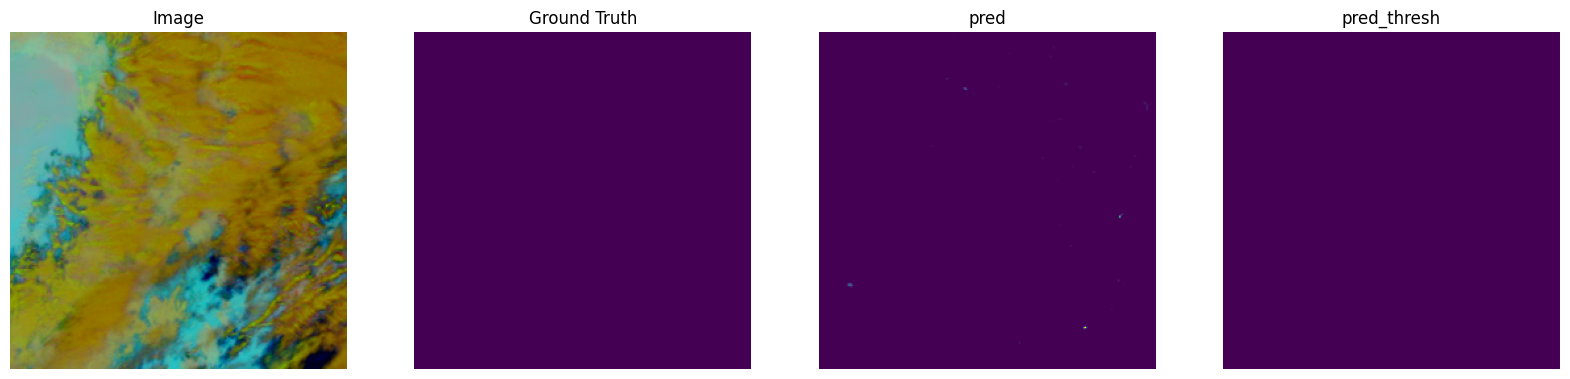

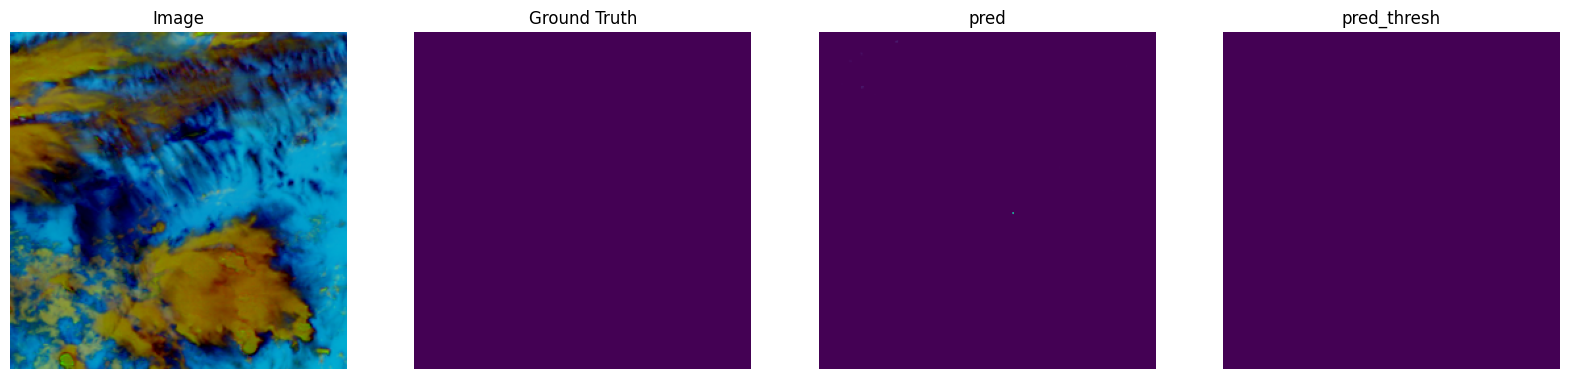

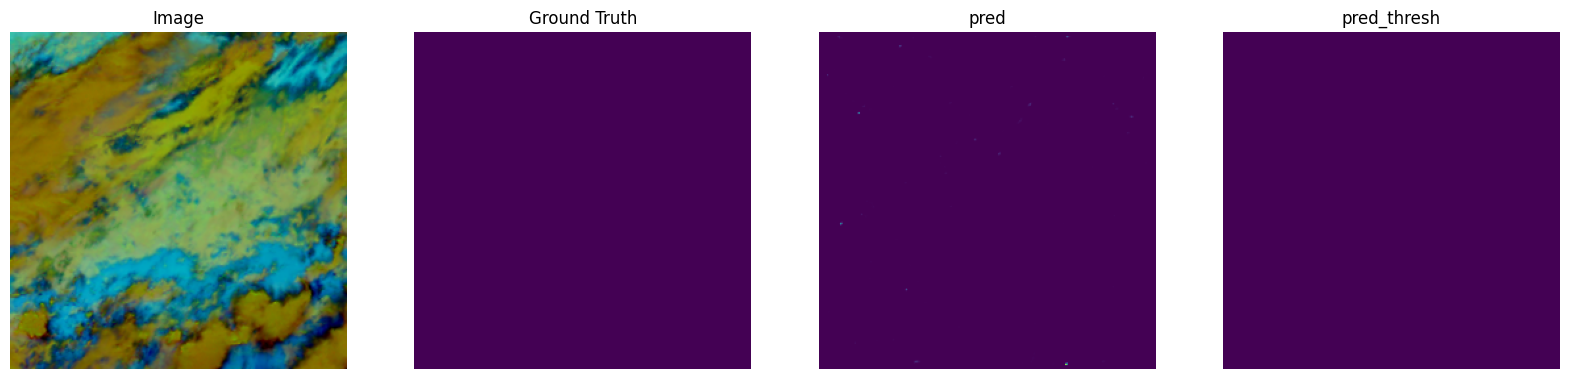

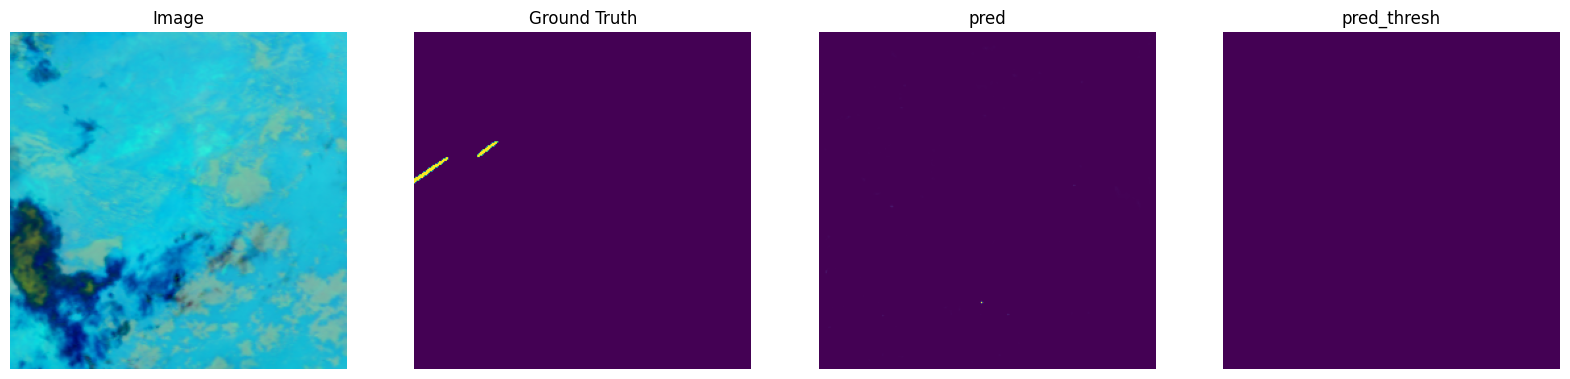

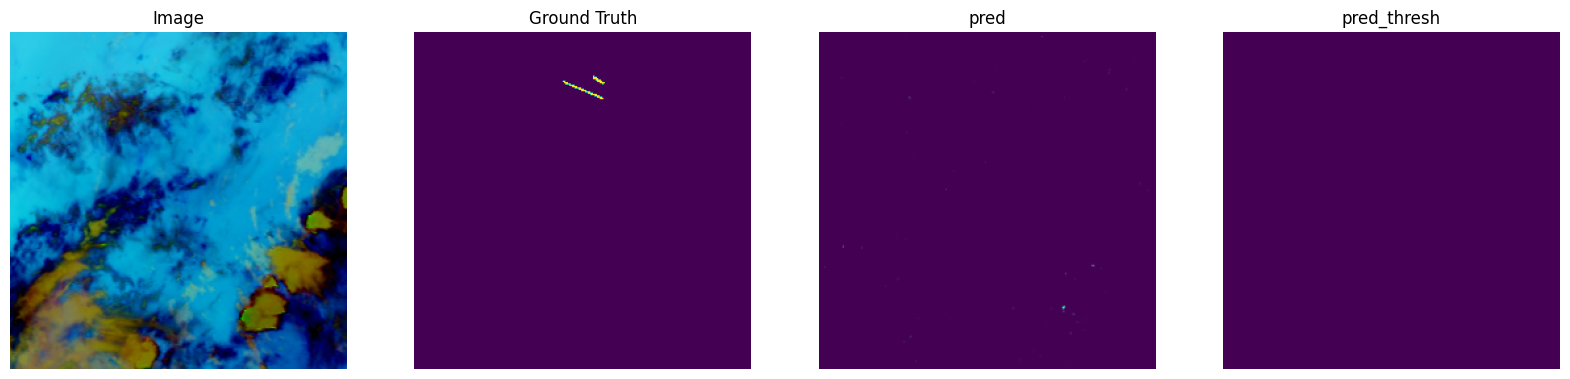

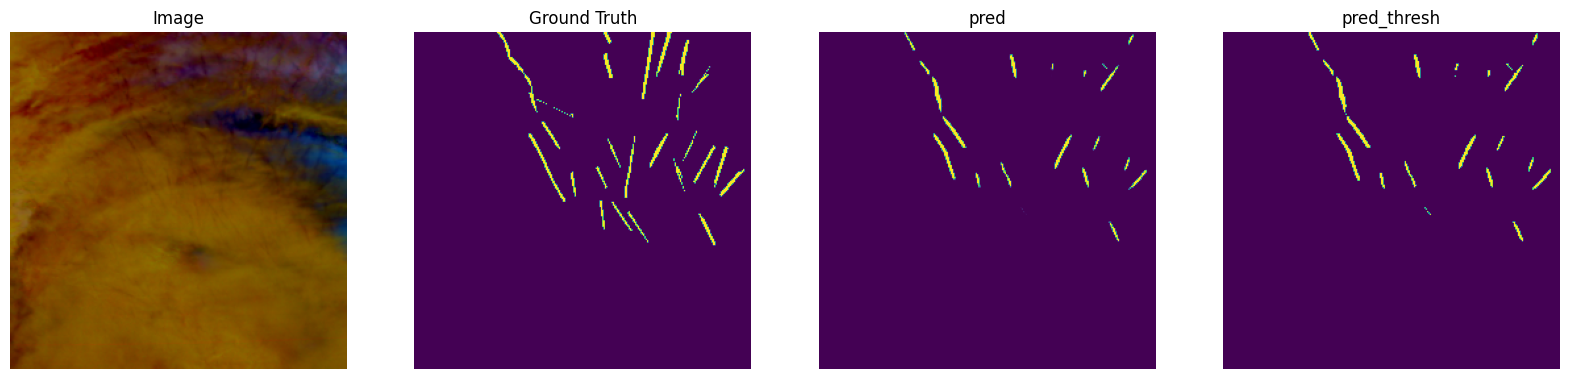

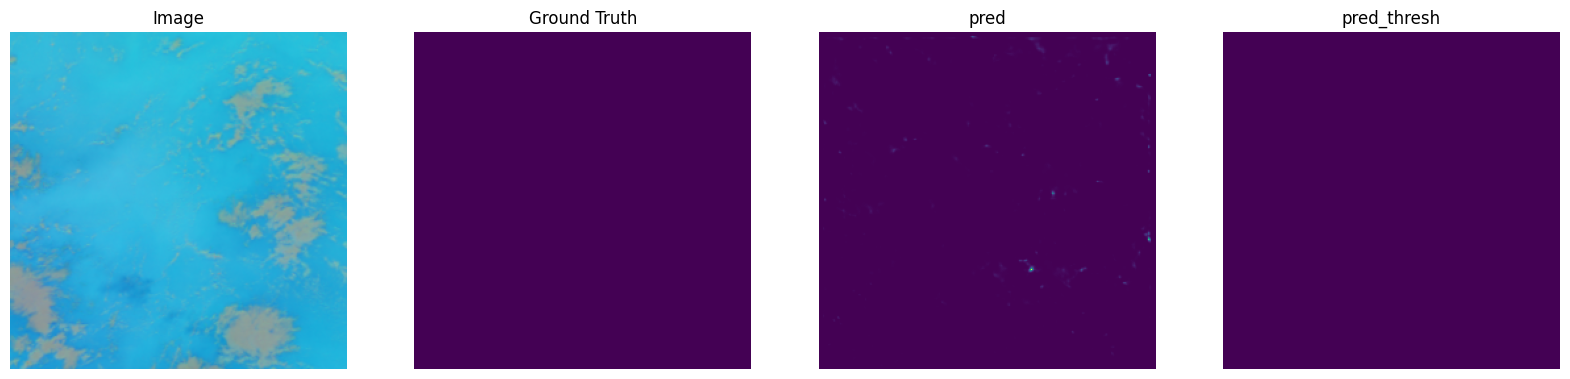

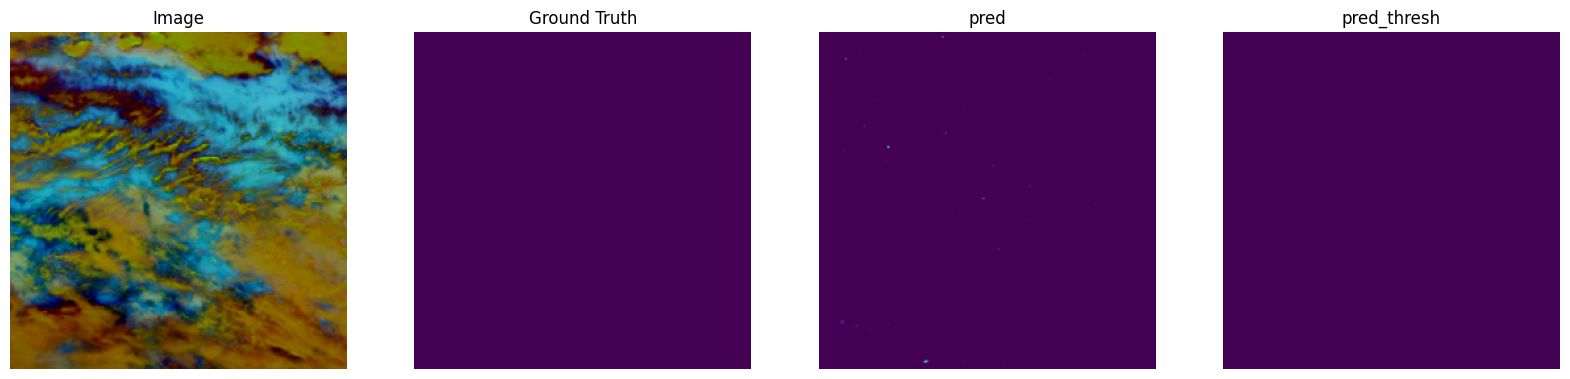

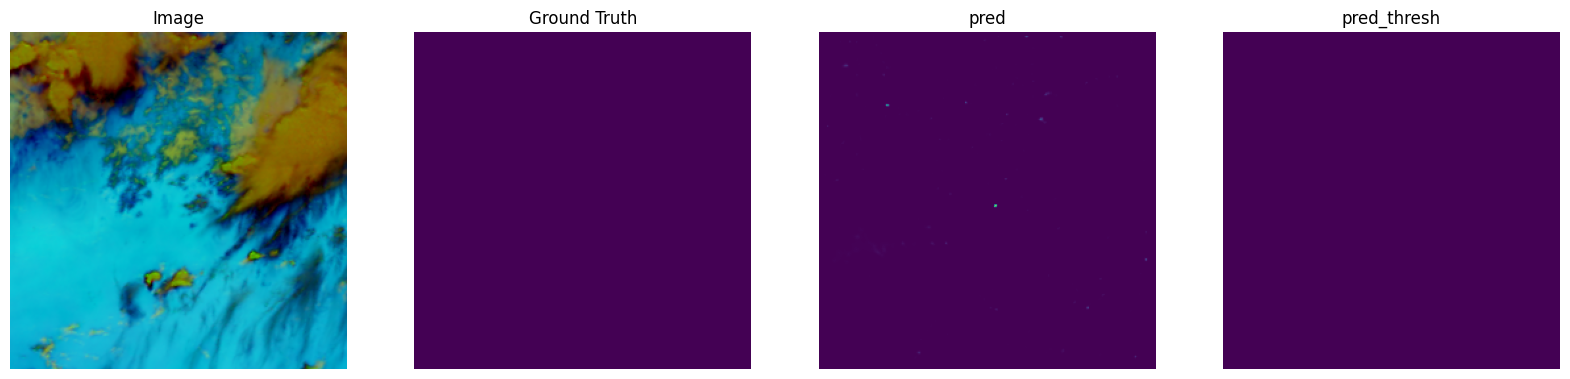

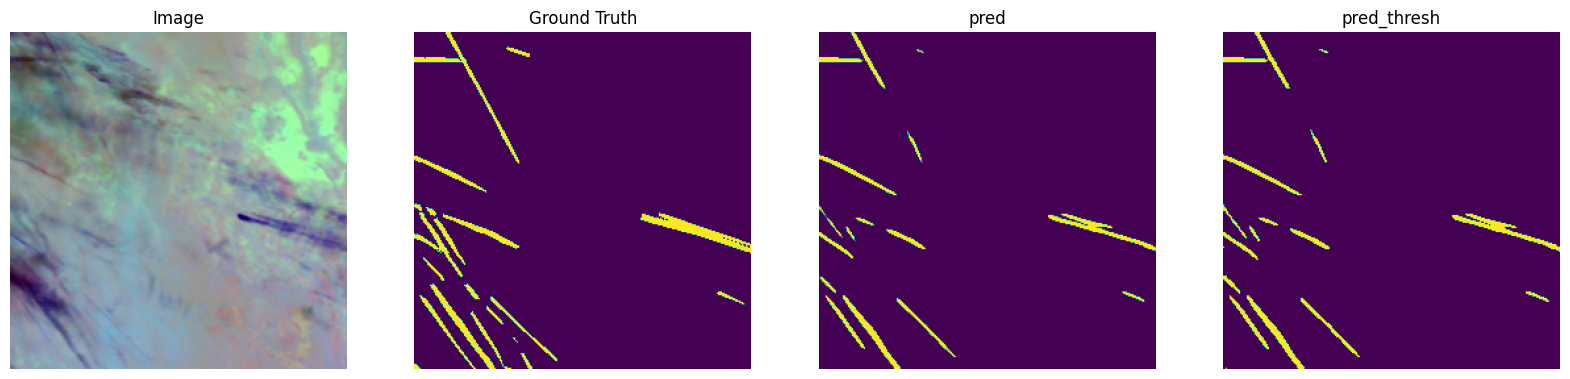

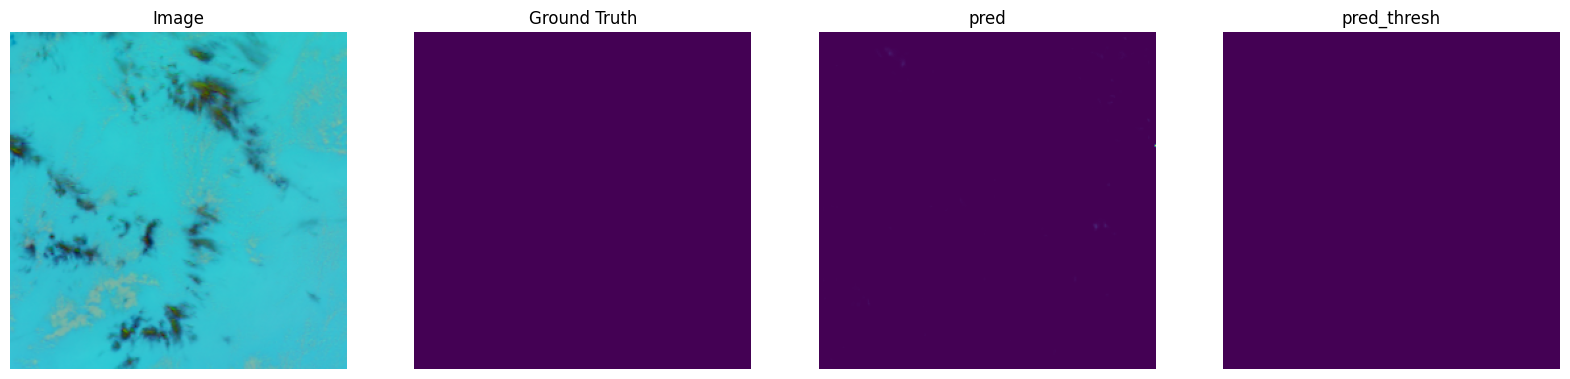

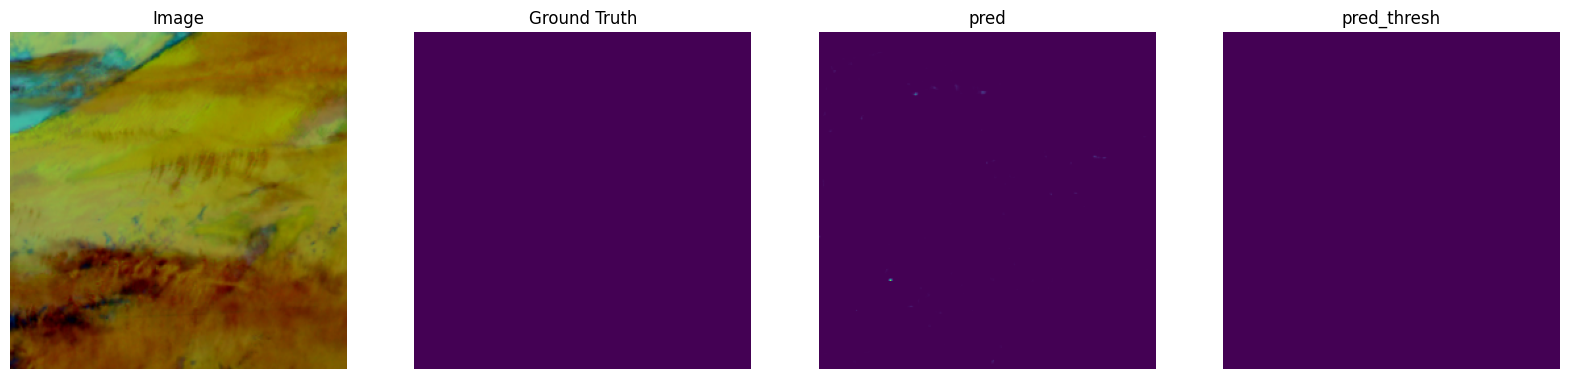

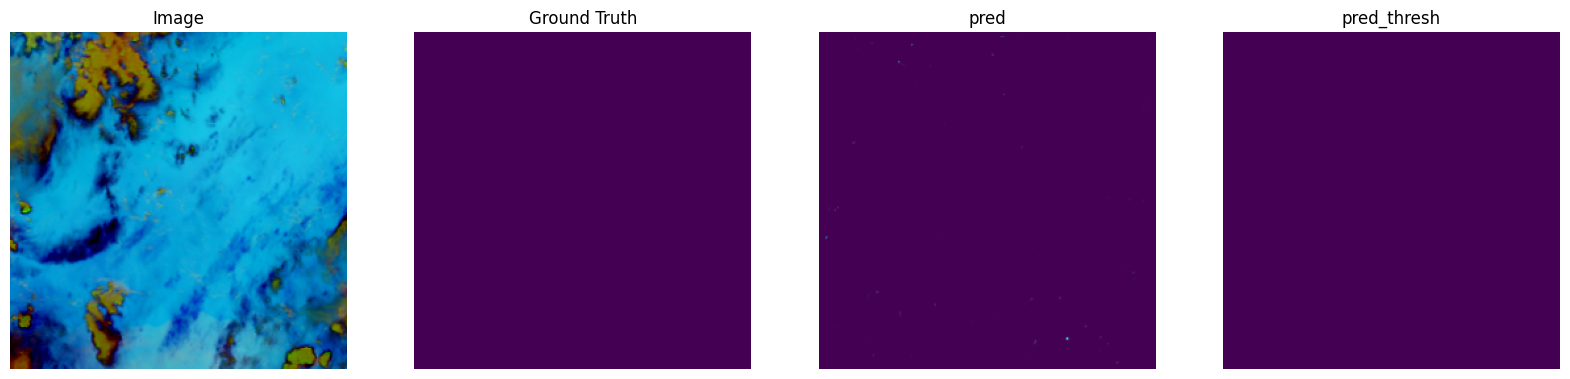

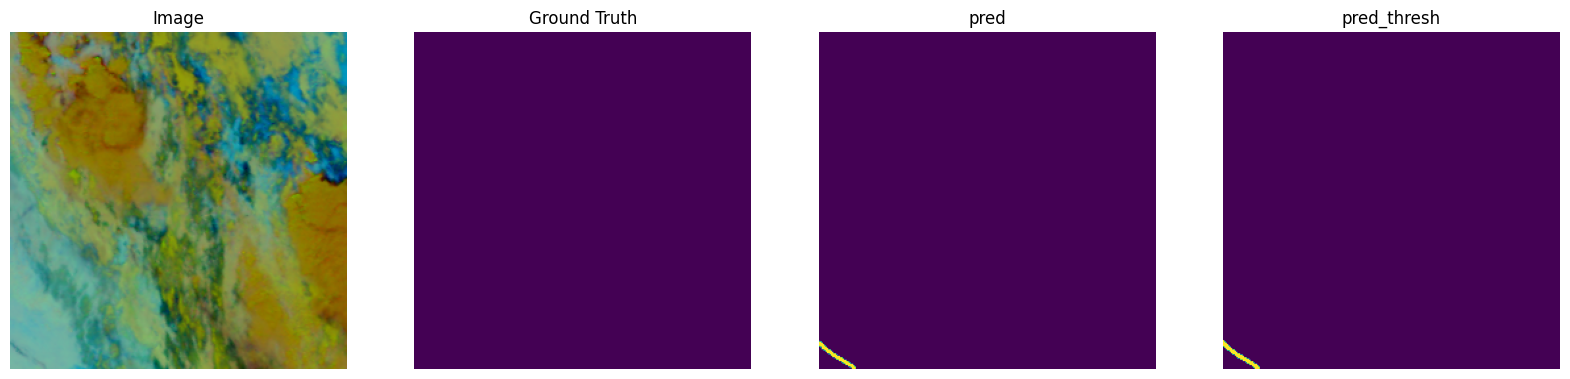

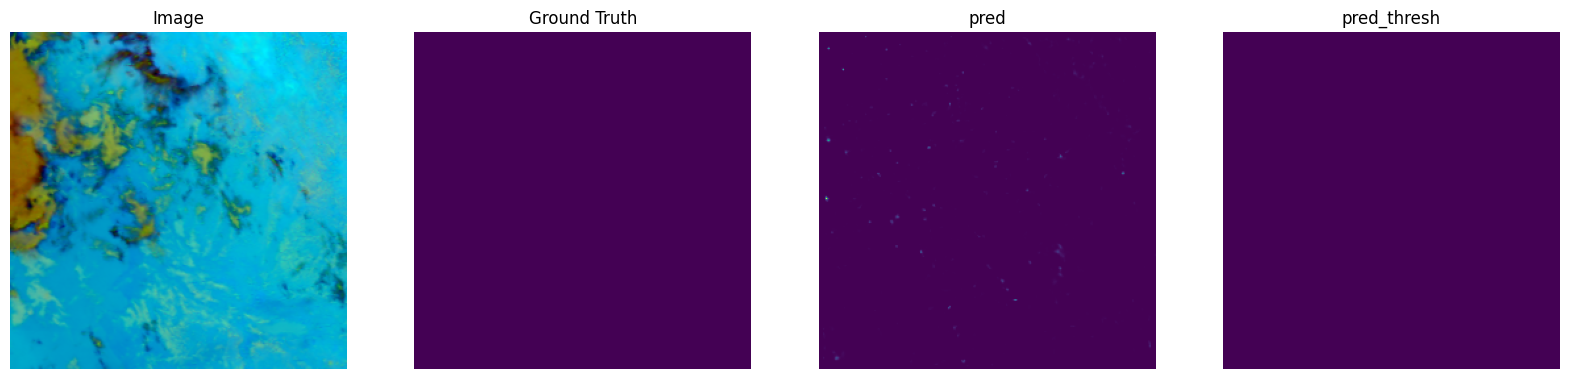

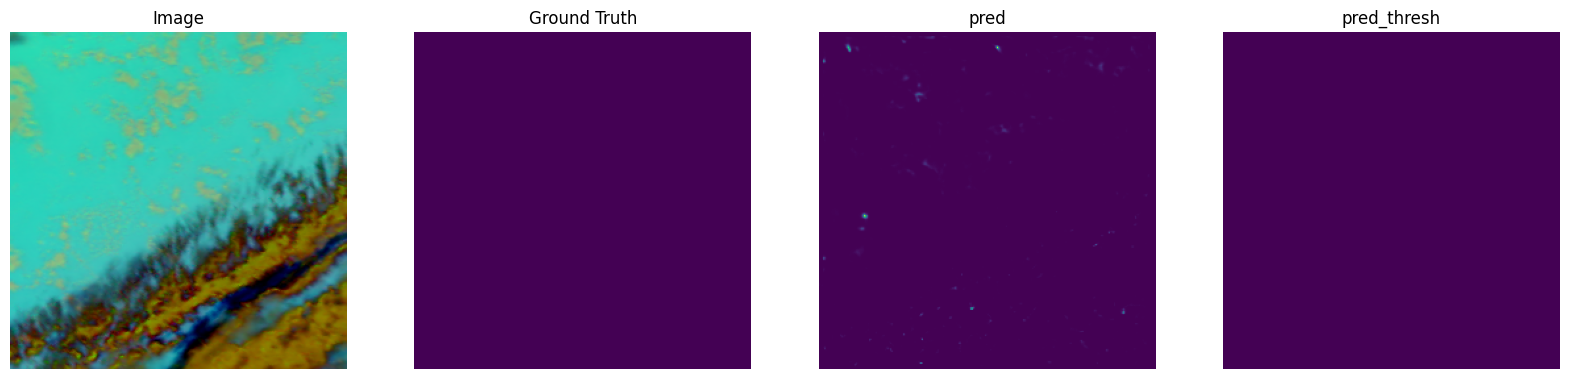

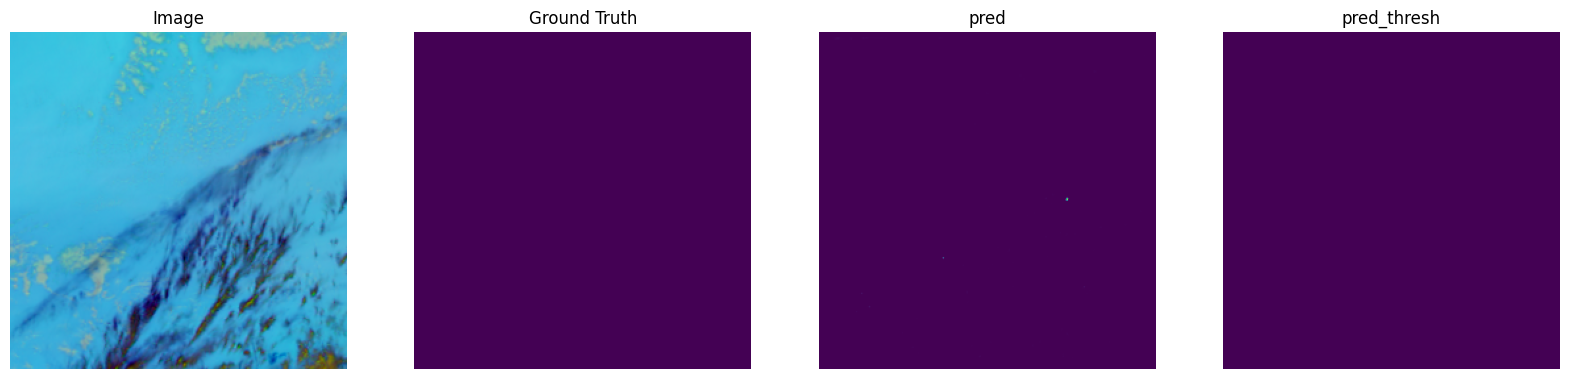

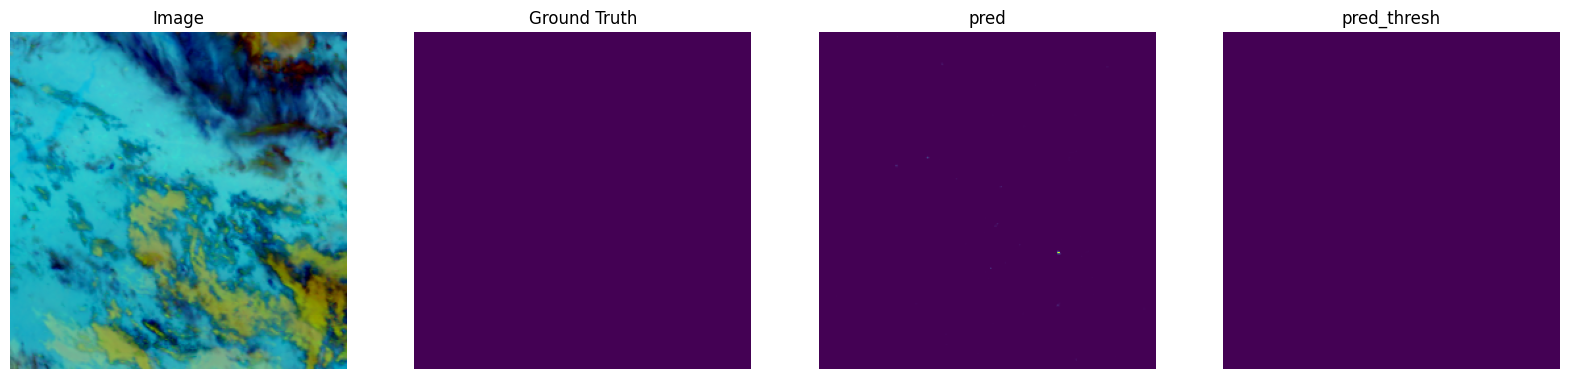

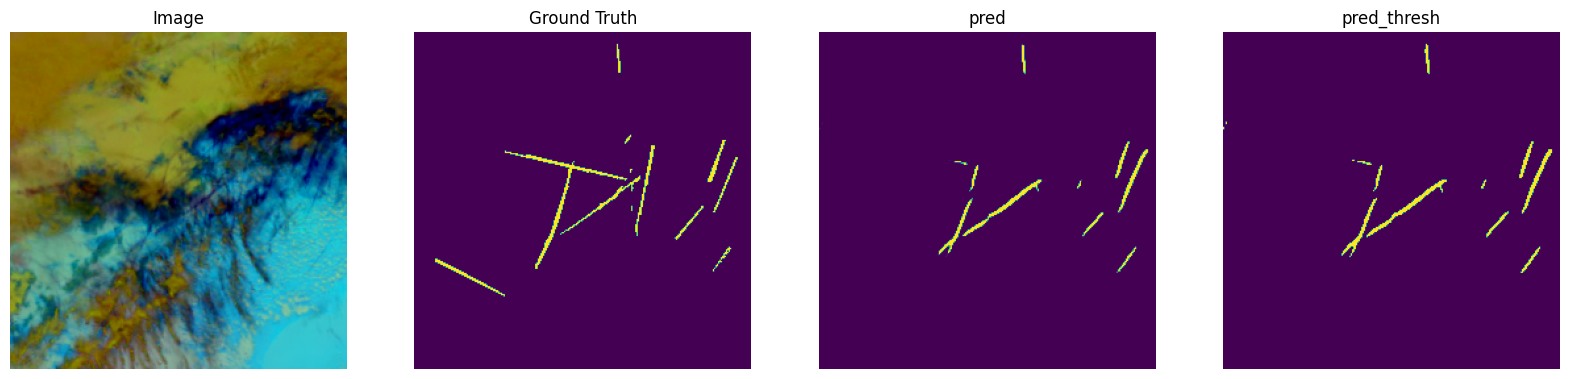

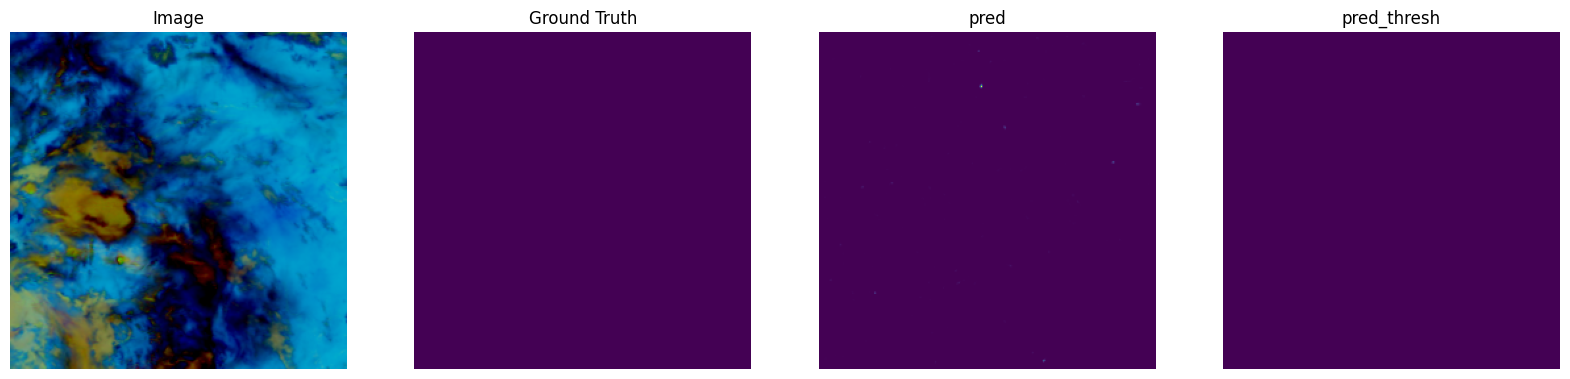

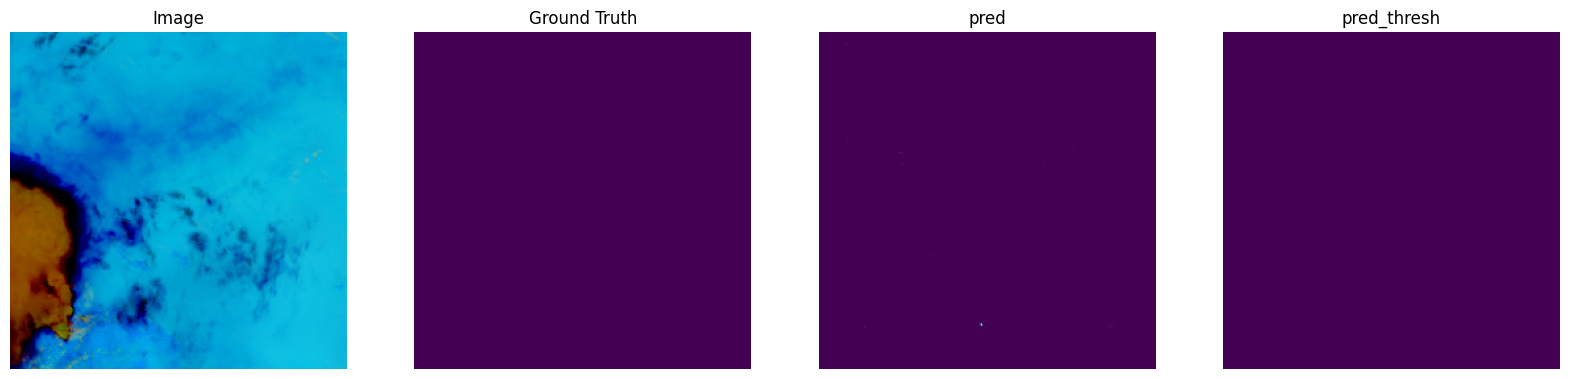

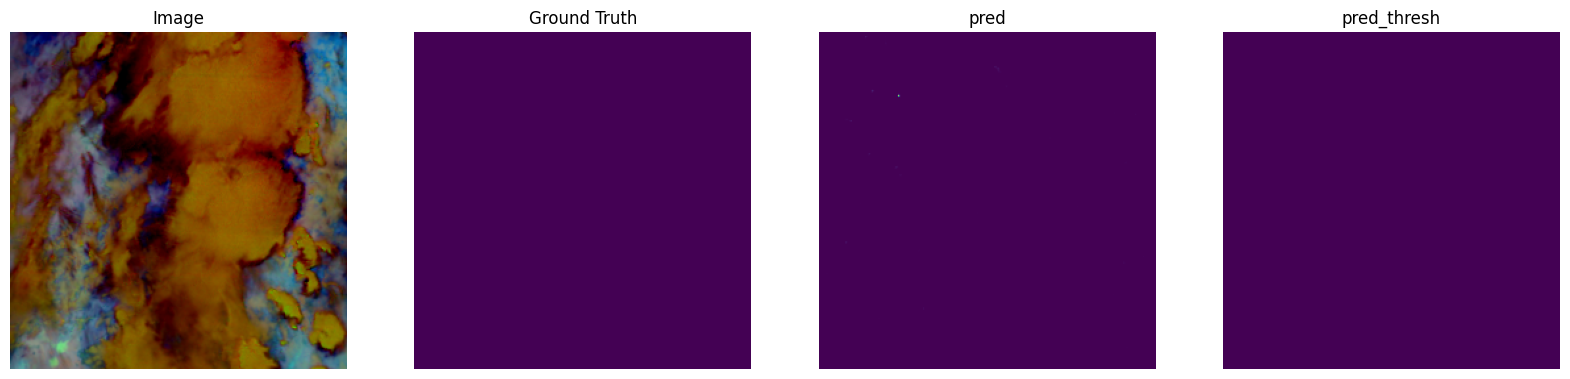

In [10]:
for i, (images, masks) in enumerate(dataloader_valid):
    if i!=1: continue
    
    images, masks = images.cuda(), masks.cuda()
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds)
    images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
    for num in range(CFG.valid_batch_size):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
        axes = axes.flatten()
        axes[0].imshow(images[num].permute(1,2,0))
        axes[0].axis('off')
        axes[0].set_title('Image')
        axes[1].imshow(masks[num].permute(1,2,0))
        axes[1].axis('off')
        axes[1].set_title('Ground Truth')
        axes[2].imshow(preds[num].permute(1,2,0))
        axes[2].axis('off')
        axes[2].set_title('pred')
        axes[3].imshow((preds[num]>thresh).permute(1,2,0))
        axes[3].axis('off')
        axes[3].set_title('pred_thresh')
    break